In [1]:
import numpy as np
from Bio.Cluster import kcluster, pca
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.manifold import MDS
import re
from Bio import AlignIO

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt 

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Getting distances

##### Using the ADs defined without smoothing

In [3]:
# Reading in sequences without the WxxLF motif
no_motif_file = "ActivationDomainsWithoutWxxLF_Corrected.txt"

with open(no_motif_file, "r") as f:
    no_motif_seqs = f.readlines()

no_motif_seqs = [seq.strip() for seq in no_motif_seqs]
no_motif_seq_len = len(no_motif_seqs)

In [4]:
# Reading in sequences with the WxxLF motif
motif_file = "ActivationDomainsWithWxxLF.txt"

with open(motif_file, "r") as f:
    motif_seqs = f.readlines()

motif_seqs = [seq.strip() for seq in motif_seqs]

motif_seq_len = len(motif_seqs)

In [5]:
# Writing all the sequences to a fasta file
all_file = "top_active_seqs.fasta"

with open(all_file, "w+") as f:
    for i, seq in enumerate(motif_seqs):
        f.write(">" + str(i) + "WLF" + "\n")
        f.write(seq + "\n")
    for i, seq in enumerate(no_motif_seqs):
        f.write(">" + str(i) + "noWLF" + "\n")
        f.write(seq + "\n")

In [6]:
# Align the sequences
! mafft --auto --distout top_active_seqs.fasta > top_active_seqs_mafft.fasta 

nthread = 0
nthreadpair = 0
nthreadtb = 0
distout=h
ppenalty_ex = 0
stacksize: 8176 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
  901 / 915
done.

Constructing a UPGMA tree (efffree=0) ... 
  910 / 915
done.

Progressive alignment 1/2... 
STEP   601 / 914 
Reallocating..done. *alloclen = 1396
STEP   901 / 914  h
done.

Making a distance matrix from msa.. 
  900 / 915
done.

Constructing a UPGMA tree (efffree=1) ... 
  910 / 915
done.

Progressive alignment 2/2... 
STEP   701 / 914 
Reallocating..done. *alloclen = 1448
STEP   901 / 914 
done.

disttbfast (aa) Version 7.526
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct)

### Using the ADs defined using the smoothed data

Using the smoothed data gives more consistent AD lengths between the two groups.
Differences from length should be minimized. 

In [7]:
# In "longer" no motif file, shorter ADs have been removed
no_motif_file = "ADs_without_WxxLF_FromSmoothedData_Thresh94031_longer.fasta"
motif_file = "ADs_with_WxxLF_FromSmoothedData_Thresh94031.fasta"
# no_motif_file = "ADs_without_WxxLF_FromSmoothedData_Thresh94031.fasta"


# all_file = "top_active_seqs_smoothed.fasta"
all_file = "top_active_seqs_smoothed_longer.fasta"

with open(no_motif_file, "r") as f:  
    no_motif_data = f.readlines()

with open(motif_file, "r") as f:  
    motif_data = f.readlines()

# Writing data to a fasta file
with open(all_file, "w+") as f:
    motif_seq_len=0
    for seq in motif_data:
        if seq.startswith(">"):
            f.write(f">motif_{motif_seq_len}\n")
            motif_seq_len+=1
        else:
            f.write(seq)
    no_motif_seq_len=0
    for seq in no_motif_data:
        if seq.startswith(">"):
            f.write(f">nomotif_{no_motif_seq_len}\n")
            i+=1
        else:
            f.write(seq)

In [8]:
# Aligning the sequences
# ! mafft --auto --distout top_active_seqs_smoothed.fasta > top_active_seqs_smoothed_mafft.fasta 
! mafft --auto --distout top_active_seqs_smoothed_longer.fasta > top_active_seqs_smoothed_longer_mafft.fasta 

nthread = 0
nthreadpair = 0
nthreadtb = 0
distout=h
ppenalty_ex = 0
stacksize: 8176 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
  901 / 913
done.

Constructing a UPGMA tree (efffree=0) ... 
  910 / 913
done.

Progressive alignment 1/2... 
STEP   701 / 912  h
Reallocating..done. *alloclen = 1305
STEP   901 / 912  h
done.

Making a distance matrix from msa.. 
  900 / 913
done.

Constructing a UPGMA tree (efffree=1) ... 
  910 / 913
done.

Progressive alignment 2/2... 
STEP   801 / 912 
Reallocating..done. *alloclen = 1295
STEP   901 / 912  h
done.

disttbfast (aa) Version 7.526
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 

# Cluster sequences using the mafft distance matrix

In creating an alignment, mafft generates a distance matrix defined using kmers between sequences (not the alignment)
The distance matrix is stored in a matlab .hat2 file

In [9]:
# Reading in the distance matrix

# Change this depending on how you want to define ADs
# fname = "top_active_seqs.fasta.hat2"
fname = "top_active_seqs_smoothed.fasta.hat2"
# fname = "top_active_seqs_smoothed_longer.fasta.hat2"

i = 0
with open(fname, "r") as f:
    data = f.readlines()

num_seqs = int(data[1].strip())
dist_mtx = np.zeros((num_seqs, num_seqs))

i = 3+num_seqs
j = 1

while j < (num_seqs):
    row = []
    while len(row) < (num_seqs-j):
        # Fix misformatted row by adding space between numbers if needed
        line = re.sub(r"(\d\.\d{3})(\d)", r"\1 \2", data[i].strip())
        row += list(map(float, line.split()))
        i +=1
    dist_mtx[j-1, j:j+len(row)] = row
    j += 1

dist_mtx = dist_mtx + dist_mtx.T

In [10]:
# Use the distance matrix to create an MDS model with the desired number of dimensions
n_components = 2 
mds = MDS(n_components=n_components, random_state=25)
 
# Fit the MDS model to your data
X_reduced = mds.fit_transform(dist_mtx)

/opt/anaconda3/envs/adhunter_v2/lib/python3.9/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/opt/anaconda3/envs/adhunter_v2/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


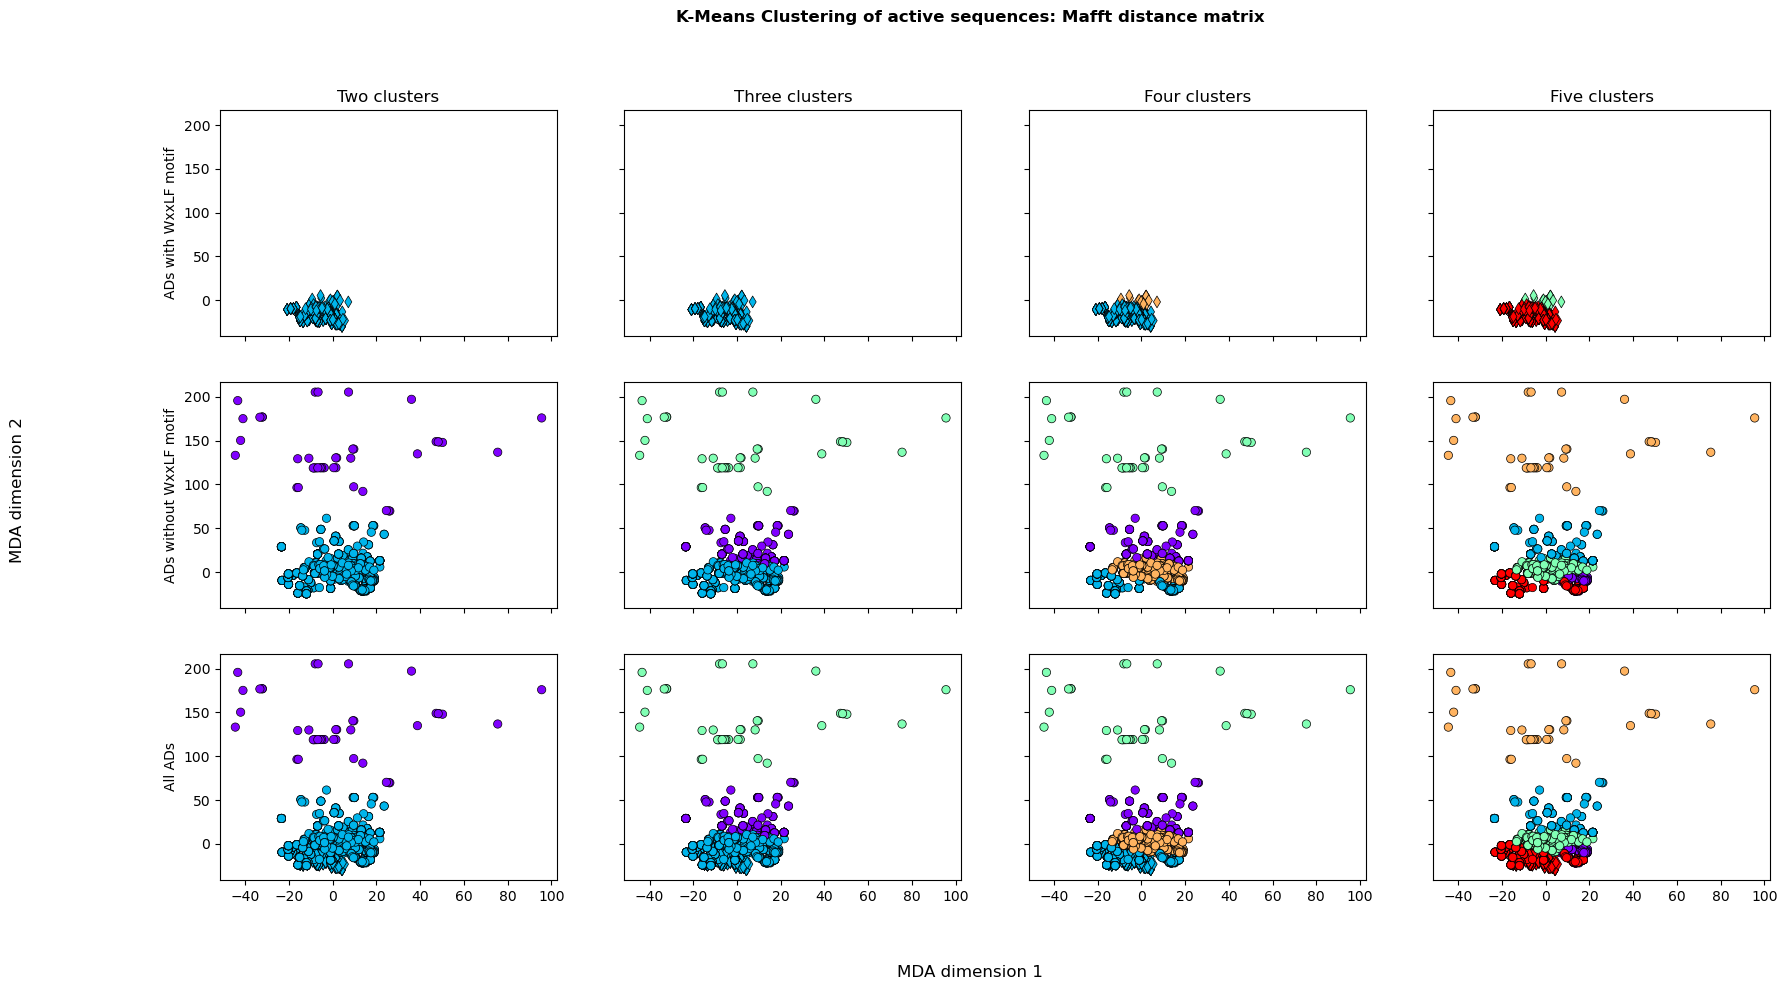

In [11]:
# Code the plot the clusters on the dimensionality reduced data
fig, axs = plt.subplots(3, 4, figsize=(20, 10), sharex=True, sharey=True)

norm = mcolors.Normalize(vmin=1, vmax=5)

for k in range(2,6):
    kcluster_result = kcluster(dist_mtx, nclusters=k)[0]
    
    # Sequences with motifs
    axs[0, k-2].scatter(X_reduced[:, 0][:motif_seq_len], X_reduced[:, 1][:motif_seq_len], c = kcluster_result[:motif_seq_len]+1, marker='d', cmap='rainbow', norm=norm, edgecolors='black', linewidths=0.5)
    axs[2, k-2].scatter(X_reduced[:, 0][:motif_seq_len], X_reduced[:, 1][:motif_seq_len], c = kcluster_result[:motif_seq_len]+1, marker='d', cmap='rainbow', norm=norm, edgecolors='black', linewidths=0.5)

    # Sequences without motifs
    axs[1, k-2].scatter(X_reduced[:, 0][motif_seq_len:], X_reduced[:, 1][motif_seq_len:], c = kcluster_result[motif_seq_len:]+1, marker='o', cmap='rainbow', norm=norm, edgecolors='black', linewidths=0.5)
    axs[2, k-2].scatter(X_reduced[:, 0][motif_seq_len:], X_reduced[:, 1][motif_seq_len:], c = kcluster_result[motif_seq_len:]+1, marker='o', cmap='rainbow', norm=norm, edgecolors='black', linewidths=0.5)


axs[0,0].set_ylabel("ADs with WxxLF motif")
axs[1,0].set_ylabel("ADs without WxxLF motif")
axs[2,0].set_ylabel("All ADs")

fig.suptitle("K-Means Clustering of active sequences: Mafft distance matrix", weight="bold")
fig.supxlabel("MDA dimension 1")
fig.supylabel("MDA dimension 2")


axs[0,0].set_title("Two clusters")
axs[0,1].set_title("Three clusters")
axs[0,2].set_title("Four clusters")
axs[0,3].set_title("Five clusters")

# fig.tight_layout()

plt.savefig("clustering_smoothedAD_mafftDistMatrix.pdf")



# Using distances calculated from the alignment

We can also calculate distances from the mafft alignment. 
It should be noted that the alignment algorithm explicity assumes that all sequences evolved from some ancestral sequence, which may not be a valid assumption.

In [12]:
# Hamming distance is common measure of quantifying differences between sequences in an alignment
def hamming_distance(s1, s2):
    if len(s1) != len(s2):
        raise ValueError("Strand lengths are not equal!")
    return sum((ch1 != ch2) for ch1,ch2 in zip(s1,s2))

# Change this depending on how you want to define the ADs
# alignment = AlignIO.read("top_active_seqs_mafft.fasta", "fasta")
# alignment = AlignIO.read("top_active_seqs_smoothed_mafft.fasta", "fasta")
alignment = AlignIO.read("top_active_seqs_smoothed_longer_mafft.fasta", "fasta")

seqs = [str(record.seq) for record in alignment]

dist = np.zeros((len(seqs), len(seqs)))
for i, line1 in enumerate(seqs):
    for j, line2 in enumerate(seqs):
        dist[i,j] = hamming_distance(line1, line2)

In [13]:
# Create an MDS model with the desired number of dimensions using the distance matrix
n_components = 2 
mds = MDS(n_components=n_components, random_state=25)
 
# Fit the MDS model to your data
X_reduced_h = mds.fit_transform(dist)

/opt/anaconda3/envs/adhunter_v2/lib/python3.9/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/opt/anaconda3/envs/adhunter_v2/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Text(0.02, 0.5, 'MDA dimension 2')

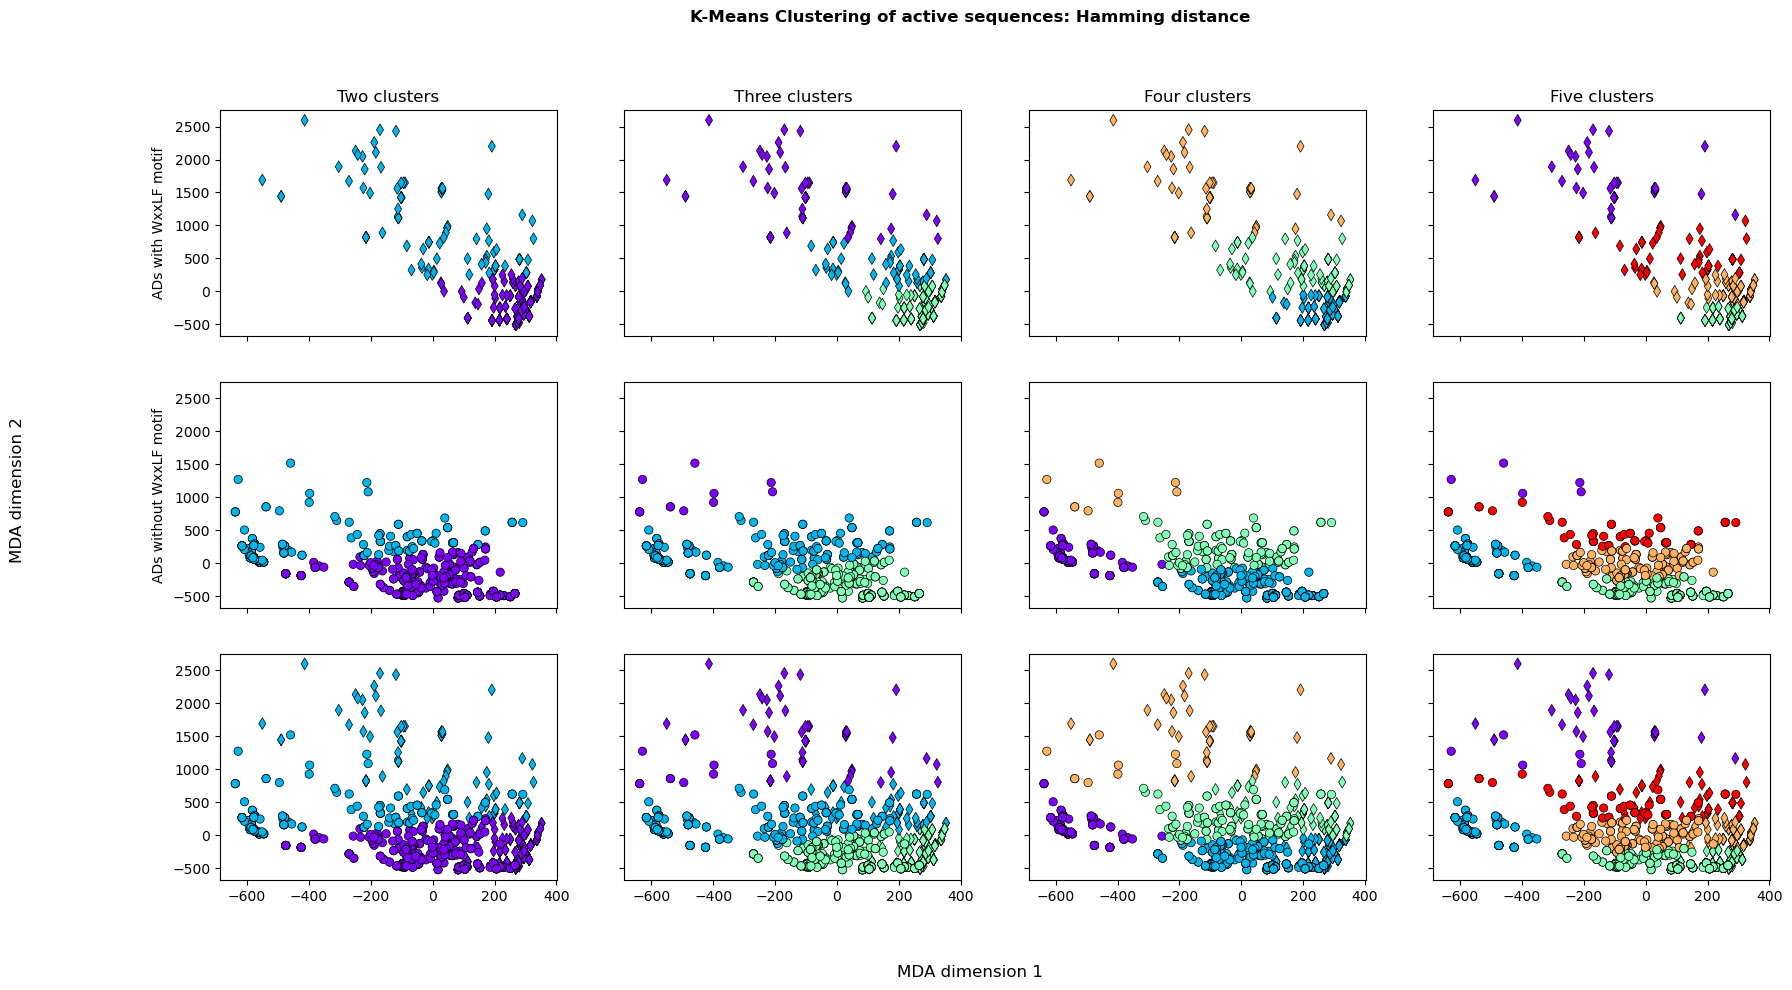

In [14]:
# Code to visualize the clusters on the dimensionality reduction of the data

fig, axs = plt.subplots(3, 4, figsize=(20, 10), sharex=True, sharey=True)

norm = mcolors.Normalize(vmin=1, vmax=5)

for k in range(2,6):
    kcluster_result = kcluster(dist, nclusters=k)[0]
    
    # sequences with the motif
    axs[0, k-2].scatter(X_reduced_h[:, 0][:motif_seq_len], X_reduced_h[:, 1][:motif_seq_len], c = kcluster_result[:motif_seq_len]+1, marker='d', cmap='rainbow', norm=norm, edgecolors='black', linewidths=0.5)
    axs[2, k-2].scatter(X_reduced_h[:, 0][:motif_seq_len], X_reduced_h[:, 1][:motif_seq_len], c = kcluster_result[:motif_seq_len]+1, marker='d', cmap='rainbow', norm=norm, edgecolors='black', linewidths=0.5)
    
    # sequences without the motif
    axs[1, k-2].scatter(X_reduced_h[:, 0][motif_seq_len:], X_reduced_h[:, 1][motif_seq_len:], c = kcluster_result[motif_seq_len:]+1, marker='o', cmap='rainbow', norm=norm, edgecolors='black', linewidths=0.5)
    axs[2, k-2].scatter(X_reduced_h[:, 0][motif_seq_len:], X_reduced_h[:, 1][motif_seq_len:], c = kcluster_result[motif_seq_len:]+1, marker='o', cmap='rainbow', norm=norm, edgecolors='black', linewidths=0.5)

axs[0,0].set_title("Two clusters")
axs[0,1].set_title("Three clusters")
axs[0,2].set_title("Four clusters")
axs[0,3].set_title("Five clusters")

axs[0,0].set_ylabel("ADs with WxxLF motif")
axs[1,0].set_ylabel("ADs without WxxLF motif")

fig.suptitle("K-Means Clustering of active sequences: Hamming distance", weight="bold")
fig.supxlabel("MDA dimension 1")
fig.supylabel("MDA dimension 2")

# fig.tight_layout()